# ※ 프로젝트 목표
 
 과제명 : 딥러닝 모델을 이용한 해충 객체 탐지

- 과제 내용 : 주어진 해충 데이터셋을 이용하여 해충 객체를 탐지하는 딥러닝 모델 기반 프로그램 개발

- 데이터셋 구성 : coco 형식 해충 데이터셋 (데이터 수: 210)

train data : 147, validation data : 43, test data : 20

- 기타

* AI Hub의 해충 데이터 활용 가능

* 해충 객체를 탐지 평가 mAP

* 적용 모델의 특장점, 모델 선택 이유 설명

* 프로젝트 결과 보고서 (프로그램 구성, 학습 과정, 평가 결과, 평가 결과 분석 등 내용 포함)

** 참조 : 테스트 데이터 결과

# 0. 작업환경 설정

#### 0.1 작업 환경 생성
```sh
conda create -n BugFinderAI python=3.8
```

#### 0.2 새로 만든 가상환경으로 작업환경 변경
```sh
conda activate BugFinderAI
```

#### 0.3 git를 통해 YOLOv5를 다운로드
```sh
git clone https://github.com/ultralytics/yolov5.git
```

# 1. 라이브러리 추가

In [21]:
import cv2
import json
import os
import torch
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 2. 모델 로드

In [4]:
model = YOLO("yolov8n.pt")

# 3. 모델 로드 확인


image 1/1 C:\Users\USER\Documents\GitHub\BugFinderAI\test.png: 448x640 2 persons, 123.0ms
Speed: 3.5ms preprocess, 123.0ms inference, 484.1ms postprocess per image at shape (1, 3, 448, 640)


(-0.5, 726.5, 484.5, -0.5)

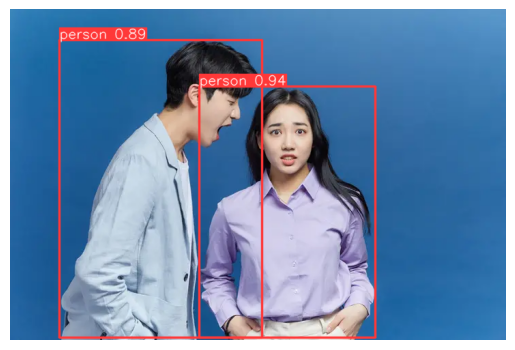

In [6]:
#사람의 객체 번호는 0이므로, 사람만 검출하도록 옵션을 지정함
results = model('test.png', classes=0)
annotated_frame = results[0].plot()[:,:,::-1]
plt.imshow(annotated_frame)
plt.axis('off')

# 4. 데이터 확인

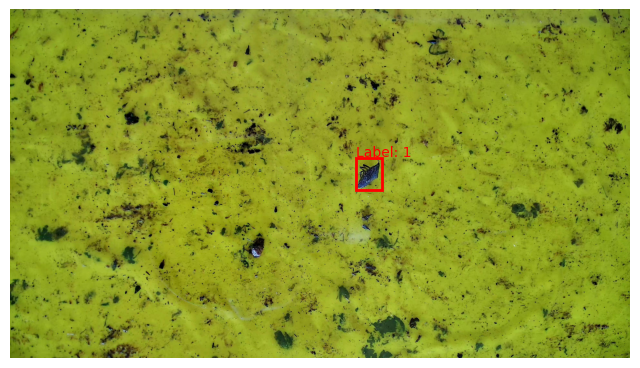

In [9]:
# JSON 파일 경로
json_file_path = 'dataset/train/_annotations.coco.json'

# 이미지 파일이 있는 디렉토리
image_dir = 'dataset/train/images'

# JSON 파일 로드
with open(json_file_path, 'r') as f:
    data = json.load(f)

# 이미지 정보 추출
images = data['images']

# 어노테이션 정보 추출
annotations = data['annotations']

# 시각화할 이미지 수 설정
num_images_to_visualize = 1

# 시각화할 이미지 수만큼 반복
for i in range(num_images_to_visualize):
    annotation = annotations[i]
    image_id = annotation['image_id']
    category_id = annotation['category_id']
    bbox = annotation['bbox']

    # 해당하는 이미지 정보 찾기
    image_info = next((image for image in images if image['id'] == image_id), None)
    if image_info:
        # 이미지 파일 이름
        file_name = image_info['file_name']
        # 이미지 파일 경로
        image_path = os.path.join(image_dir, file_name)
        # 이미지 열기
        image = plt.imread(image_path)
        
        # 이미지 시각화
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        
        # 바운딩 박스 시각화
        x, y, width, height = bbox
        plt.gca().add_patch(Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none'))
        
        # 라벨 표시
        plt.text(x, y-10, f'Label: {category_id}', color='red')
        
        plt.axis('off')
        plt.show()
    else:
        print(f"해당하는 이미지 정보를 찾을 수 없습니다. (이미지 ID: {image_id})")


# 5. COCO 형식의 JSON 데이터를 YOLO 형식의 텍스트 파일로 변환

In [16]:
import json
import os

# COCO JSON 파일 경로 리스트
coco_json_path_list = ['dataset/test/_annotations.coco.json', 'dataset/train/_annotations.coco.json', 'dataset/valid/_annotations.coco.json']

# YOLO 라벨을 저장할 디렉토리 리스트
output_dir_list = ['dataset/test/labels', 'dataset/train/labels', 'dataset/valid/labels']

# 각 COCO JSON 파일 경로와 대응하는 출력 디렉토리를 순회하며 변환
for coco_json_path, output_dir in zip(coco_json_path_list, output_dir_list):
    os.makedirs(output_dir, exist_ok=True)
    
    # COCO JSON 파일 로드
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    
    # 이미지 정보와 어노테이션 정보 매핑
    images = {image['id']: image for image in coco_data['images']}
    annotations = coco_data['annotations']
    categories = {category['id']: category['name'] for category in coco_data['categories']}
    
    # 어노테이션을 YOLO 형식으로 변환
    for annotation in annotations:
        image_id = annotation['image_id']
        image_info = images[image_id]
        
        img_width = image_info['width']
        img_height = image_info['height']
        
        category_id = annotation['category_id']
        bbox = annotation['bbox']
        
        # COCO 형식의 bbox: [x_min, y_min, width, height]
        x_min, y_min, width, height = bbox
        
        # YOLO 형식의 bbox: [x_center, y_center, width, height] (이미지 크기 비율로)
        x_center = (x_min + width / 2) / img_width
        y_center = (y_min + height / 2) / img_height
        width /= img_width
        height /= img_height
        
        # YOLO 라벨 파일 작성
        label_filename = f"{os.path.splitext(image_info['file_name'])[0]}.txt"
        label_file_path = os.path.join(output_dir, label_filename)
        
        with open(label_file_path, 'a') as f:
            f.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

    print(f"{coco_json_path} 변환 완료! 라벨은 {output_dir}에 저장되었습니다.")

dataset/test/_annotations.coco.json 변환 완료! 라벨은 dataset/test/labels에 저장되었습니다.
dataset/train/_annotations.coco.json 변환 완료! 라벨은 dataset/train/labels에 저장되었습니다.
dataset/valid/_annotations.coco.json 변환 완료! 라벨은 dataset/valid/labels에 저장되었습니다.


# 6. 학습 데이터 이동 및 구조
학습 데이터와 변경한 labels 데이터를 clone한 yolov5 폴더로 이동시킨 후 data.yaml 파일을 생성한다.

<pre style="color: black;">
yolov5
   ├─classify
   ├─data
   ├─models
   ├─runs
   ├─segment
   ├─utils
   <span style="color: blue;">├─data.yaml
   ├─test
   │  ├─images
   │  └─labels
   ├─train
   │  ├─images
   │  └─labels
   └─valid
      ├─images
      └─labels
</pre>


# 7. data.yaml 작성
```yaml
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['pest']
```
<br>

# 8. 모델 학습 수행
* yolov5 경로로 이동
```sh
    cd yolov5
```

* 모델 학습 시작
``` sh
    python train.py --img 416 --batch 16 --epochs 150 --data data.yaml --weights yolov5s.pt --cache
```
<br>

# 9. 가중치 로드 및 결과 확인

Using cache found in C:\Users\USER/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-28 Python-3.8.19 torch-2.3.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


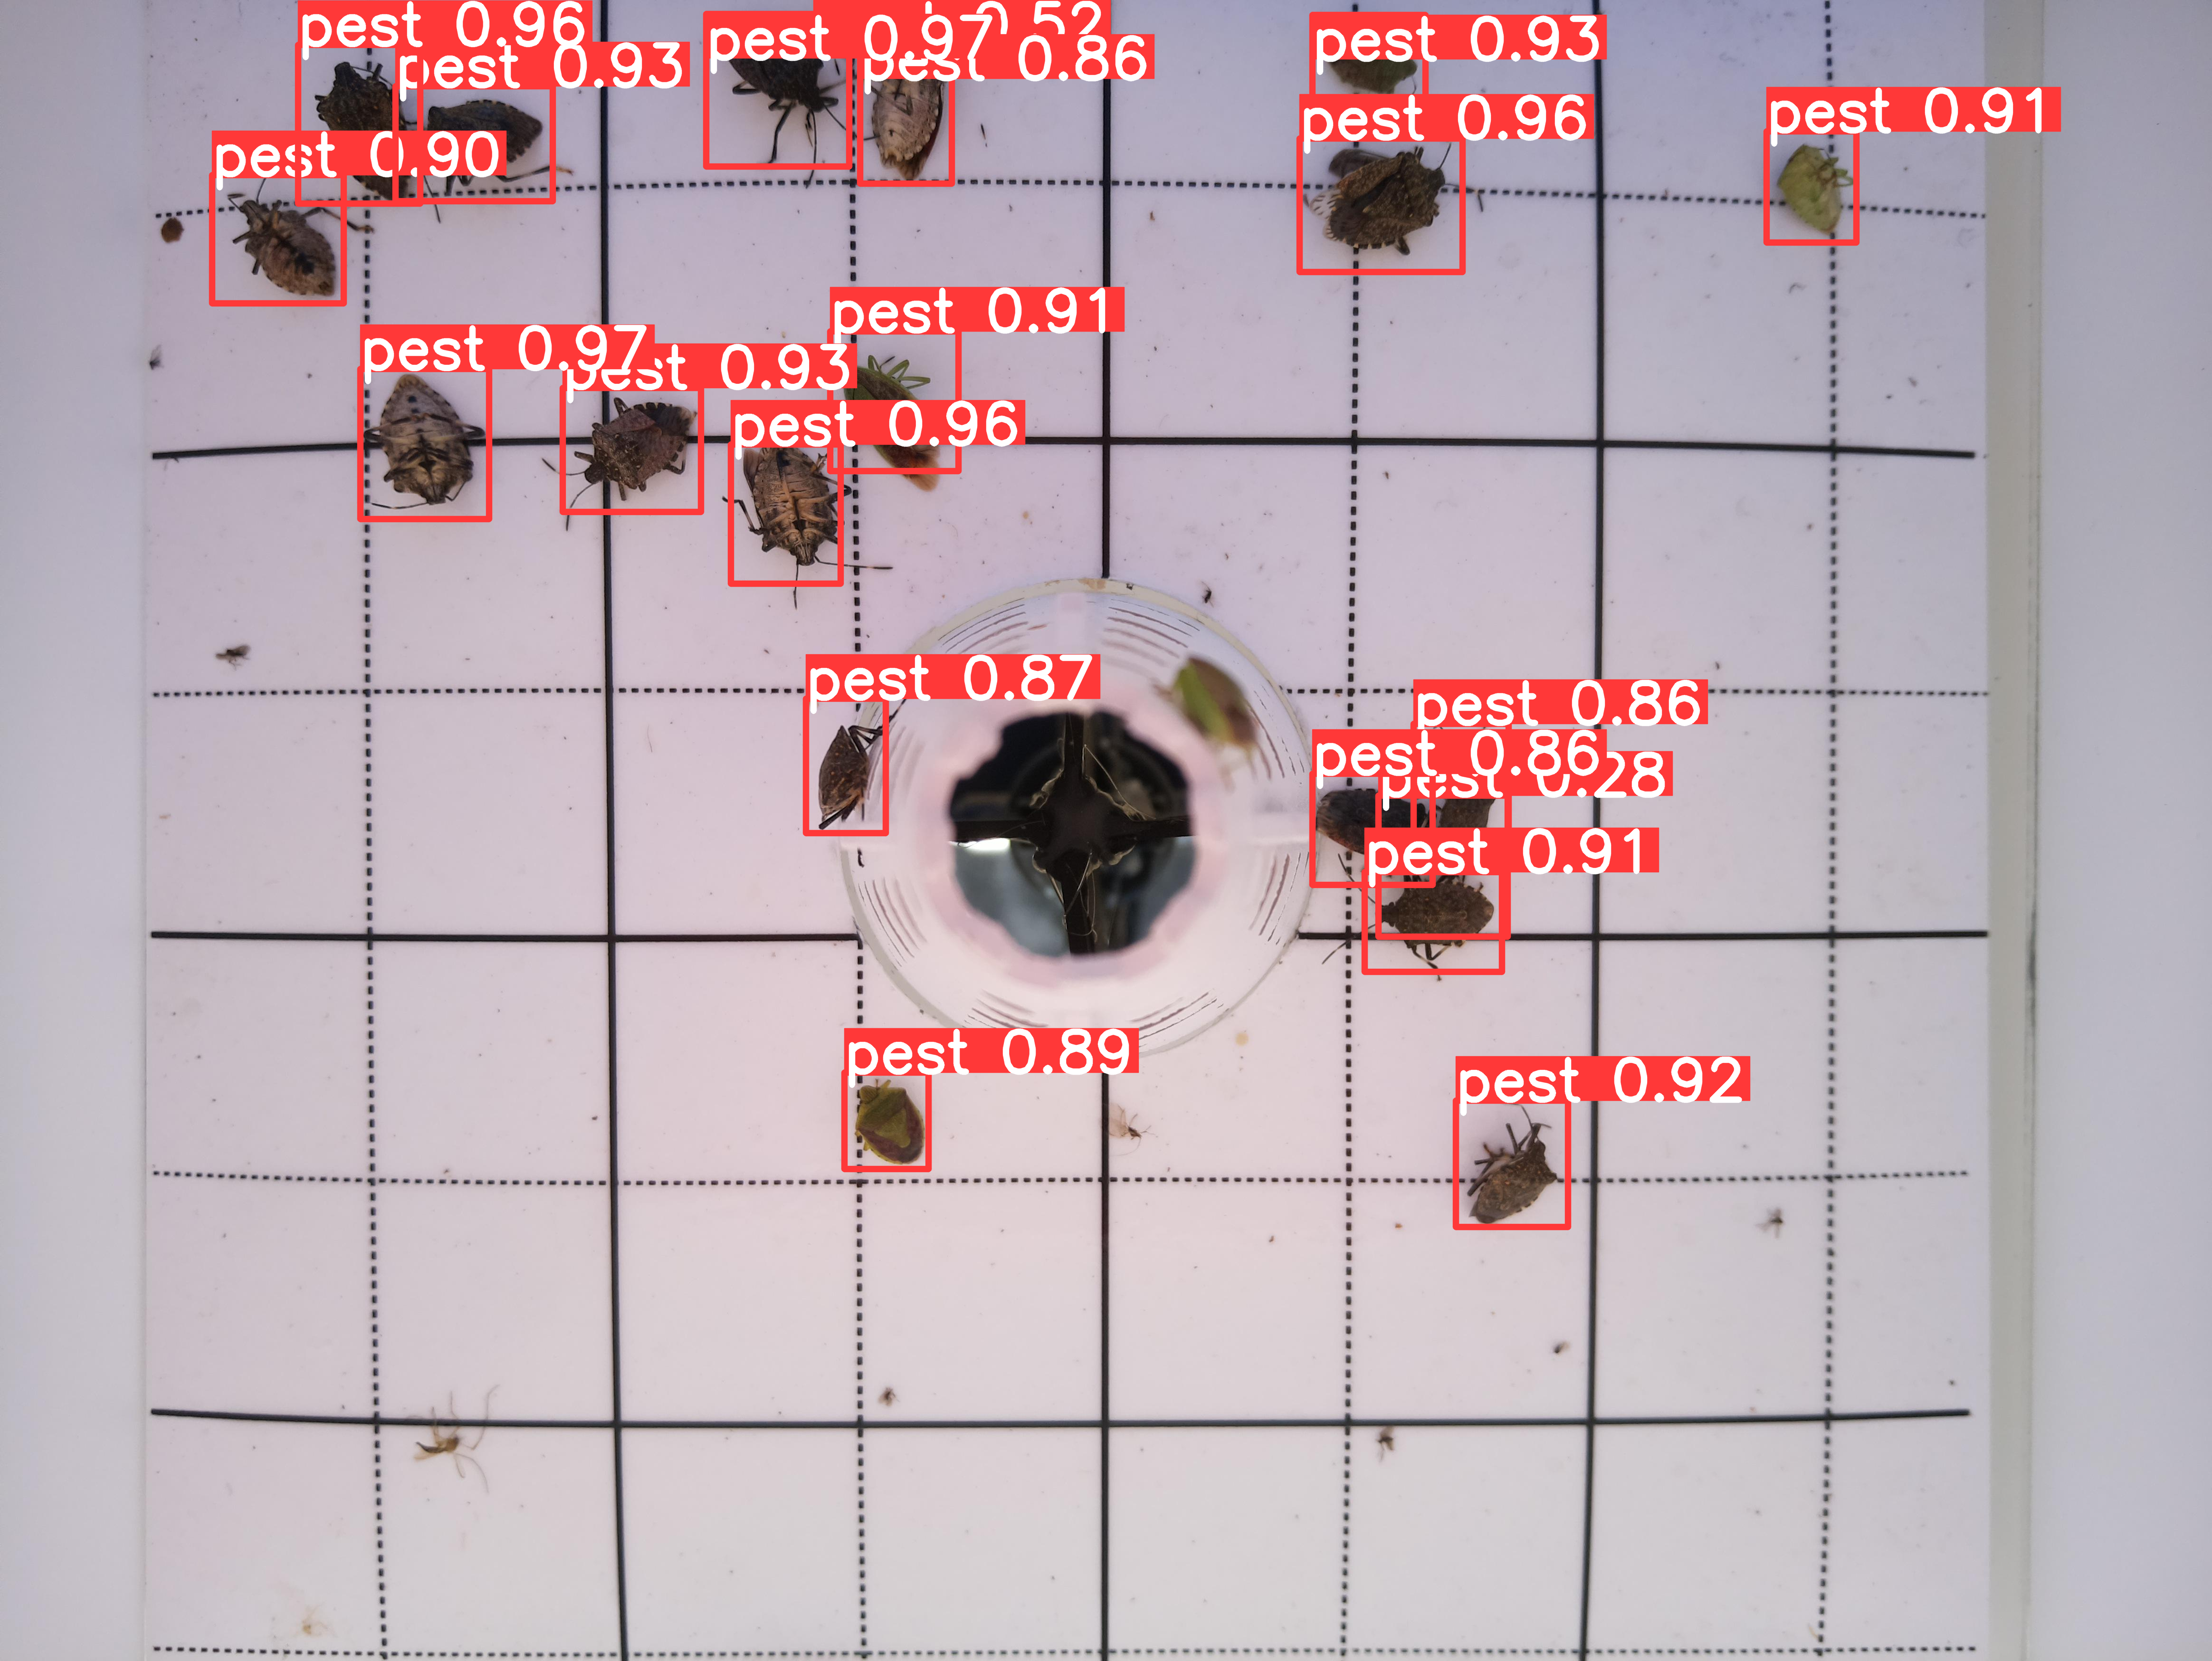

In [29]:
# 모델 로드
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp/weights/best.pt')

# 이미지 로드
img = "dataset/test/" + "capture_204_446_20231124111957021_ori_jpg.rf.b9207b7feadabff417d25989f1e74a3d.jpg"

# 예측 수행
results = model(img)

# 결과 시각화
results.show()

# 10. 모델 정확도 평가
```sh 
    python val.py --weights runs/train/exp/weights/best.pt --data test.yaml --task test
```


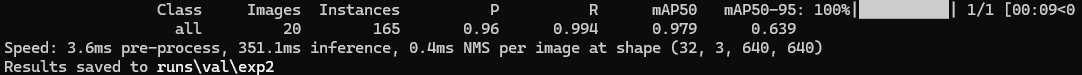
